In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures

# Contents

1. [Polynomial Regression](#Polynomial-Regression)
2. [Step Functions](#Step-Functions)
3. [Basis Functions](#Basis-Functions)
4. [Regression Splines](#Regression-Splines)
5. [Smoothing Splines](#Smoothing-Splines)
6. [Local Regression](#Local-Regression)
7. [Generalized Additive Models](#Generalized-Additive-Models)

## Introducion
In this chapter we relax the linearity assumption while still attempting to maintain as much interpretability as possible. We do this by examining very simple extensions of linear models like polynomial regression and step functions, as well as more sophisticated approaches such as splines, local regression, and generalized additive models.

**Polynomial regression** extends the linear model by adding extra predictors, obtained by raising each of the original predictors to a power.

**Step functions** cut the range of a variable into K distinct regions in order to produce a qualitative variable. This has the effect of fitting a piecewise constant function.

**Regression splines** are more flexible than polynomials and step functions, and in fact are an extension of the two. They involve dividing the range of $X$ into $K$ distinct regions. Within each region, a polynomial function is fit to the data. However, these polynomials are constrained so that they join smoothly at the region boundaries, or *knots*. Provided that the interval is divided into enough regions, this can produce an extremely flexible fit.

**Smoothing splines** are similar to regression splines, but arise in a slightly different situation. Smoothing splines result from minimizing a residual sum of squares criterion subject to a smoothness penalty.

**Local regression** is similar to splines, but differs in an important way. The regions are allowed to overlap, and indeed they do so in a very smooth way.

**Generalized additive models** allow us to extend the methods above to deal with multiple predictors.

We will start with a single predictor $X$ and move onto several $X_1, \ldots, X_p$ predictors at the end of the chapter.

---

# Polynomial Regression
Historically, the standard way to extend linear regression to settings in which the relationship between the predictors and the response is non-linear has been to replace the standard linear model

\begin{align*}
    y_i = \beta_0 + \beta_1 x_i + \epsilon_i
\end{align*}

with a polynomial function

\begin{equation}\label{7.1}
    y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \ldots + \beta_d x_i^d + \epsilon_i
    \tag{7.1}
\end{equation}

where $\epsilon_i$ is the error term. This approach is known as **polynomial regression**. Notice that the coefficients in (7.1) can be easily estimated using least squares linear regression because this is just a standard linear model with predictors $x_i, x^2_i, x^3_i , \ldots, x^d_i$. Generally speaking, it is unusual
to use d greater than 3 or 4 because for large values of $d$, the polynomial curve can become overly flexible and can take on some very strange shapes. This is especially true near the boundary of the $X$ variable.

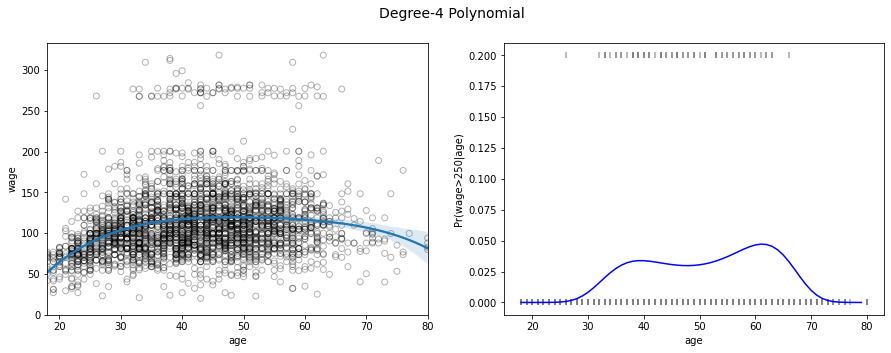

In [2]:
# The Wage data
df = pd.read_csv('../data/Wage.csv')

# The polynomial fit for the logistic regression
X = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
y = (df.wage > 250).map({False:0, True:1}).values

# Generalized linear model estimation using the one-parameter exponential families.
clf = sm.GLM(y, X, family=sm.families.Binomial())
res = clf.fit()

age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# The polynomial fit
X_test = PolynomialFeatures(4).fit_transform(age_grid)
pred = res.predict(X_test)

# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot(df.age, df.wage, order = 4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

>**Figure 7.1.** *Left*: The solid blue curve is a degree-4 polynomial of wage (in thousands of dollars) as a function of age, fit by least squares. The light-blue area indicates an estimated 95% confidence interval.  
*Right*: We model the binary event $\text{wage}>250$ using logistic regression, again with a degree-4 polynomial.

**Even though this is a linear regression model like any other, the individual coefficients are not of particular interest.** Instead, we look at the entire fitted function across a grid of 62 values for age from 18 to 80 in order to understand the relationship between age and wage.

In Figure 7.1, a pair of dotted curves accompanies the fit; these are ($2 \times$) standard error curves. Let’s see how these arise. Suppose we have computed the fit at a particular value of age, $x_0$:

\begin{equation}\label{7.2}
    \hat{f}(x_0) = \hat{\beta}_0 + \hat{\beta}_1 x_0 + \hat{\beta}_2 x_0^2 + \hat{\beta}_3 x_0^3 + \hat{\beta}_4 x_0^4
    \tag{7.2}
\end{equation}

What is the variance of the fit, i.e. $\text{Var} \hat{f}(x_0)$? Least squares returns variance estimates for each of the fitted coefficients $\hat{\beta}_j$, as well as the covariances between pairs of coefficient estimates. We can use these to compute the estimated variance of $\text{Var} \hat{f}(x_0)$. The estimated *pointwise* standard error of $\text{Var} \hat{f}(x_0)$ is the square-root of this variance. This computation is repeated at each reference point $x_0$, and we plot the fitted curve, as well as twice the standard error on either side of the fitted curve. We plot twice the standard error because, for normally distributed error terms, this quantity corresponds to an approximate 95% confidence interval.

It seems like the wages in Figure 7.1 are from two distinct populations: there appears to be a *high earners* group earning more than $ \$ 250,000$ per annum, as well as a *low earners* group. We can treat wage as a binary
variable by splitting it into these two groups. Logistic regression can then be used to predict this binary response, using polynomial functions of age as predictors. In other words, we fit the model

\begin{equation}\label{7.3}
    \text{Pr}(y_i > 250 | x_i) = \frac{\text{exp}(\beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \ldots + \beta_d x_i^d)}{1+\text{exp}(\beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \ldots + \beta_d x_i^d)}
    \tag{7.3} 
\end{equation}

The gray marks on the top and bottom of the panel indicate the ages of the high earners and the low earners. The solid blue curve indicates the fitted probabilities of being a high earner, as a function of age.

---

# Step Functions
Using polynomial functions of the features as predictors in a linear model imposes a global structure on the non-linear function of $X$. We can instead use step functions in order to avoid imposing such a global structure. Here we break the range of $X$ into *bins*, and fit a different constant in each bin. This amounts to converting a continuous variable into an *ordered categorical variable*.

In greater detail, we create cutpoints $c_1, c_2, \ldots, c_K$ in the range of $X$, and then construct $K + 1$ new variables:

\begin{align*}\label{7.4}
    C_0(X) &= I(X < c_1), \\
    C_1(X) &= I(c_1 \le X < c_2), \\
    C_2(X) &= I(c_2 \le X < c_3), \\
           &\vdots \tag{7.4} \\
    C_{K-1}(X) &= I(c_{K-1} \le X < c_K), \\
    C_K(X) &= I(c_K \le X),
\end{align*}

where $I(\cdot)$ is an *indicator function* that returns a 1 if the condition is true, and returns a 0 otherwise. Notice that for any value of $X$, $C_0(X) + C_1(X) + \ldots + C_K (X) = 1$, since $X$ must be in exactly one of the $K + 1$ intervals. We then use least squares to fit a linear model using $C_1(X), C_2 (X), \ldots, C_K (X)$ as predictors:

\begin{equation}\label{7.5}
    y_i = \beta_0 + \beta_1 C_1(x_i) + \beta_2 C_2(x_i) + \ldots + \beta_K C_K(x_i) + \epsilon_i
    \tag{7.5}
\end{equation}

For a given value of $X$, at most one of $C_0(X) + C_1(X) + \ldots + C_K (X)$ can be non-zero. Note that when $X < c_1$, all of the predictors in (\ref{7.5}) are zero, so $\beta_0$ can be interpreted as the mean value of $Y$ for $X < c_1$. By comparison, (\ref{7.5}) predicts a response of $\beta_0 + \beta_j$ for $c_j \le X < c_{j+1}$, so $\beta_j$ represents the average increase in the response for $X$ in $c_j \le X < c_{j+1}$ relative to $X < c_1$.

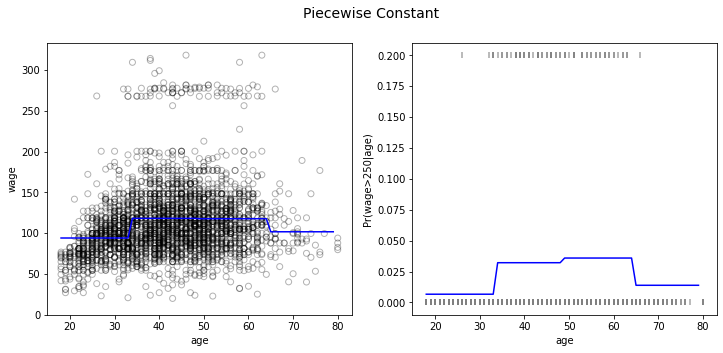

In [3]:
# Cut the age into 4 bins
# Place the ages into steps
df_cut, bins = pd.cut(df.age, 4, retbins=True, right=True)
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age','age_cuts','wage'], axis=1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

# Using statsmodels because it has a more complete output for coefficients
fit3 = sm.GLM(df_steps.wage, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1)).fit()

# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)

# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))

# Generate predictions from Stepwise model
pred2 = fit3.predict(X_test2)

# Generate predictions for Pr(wage>250)
clf2 = sm.GLM(y, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1),
              family=sm.families.Binomial())
res2 = clf2.fit()
pred3 = res2.predict(X_test2)



# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred2, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

> **Figure 7.2.** *Left*: The solid curve displays the fitted value from a least squares regression of wage  
(in thousands of dollars) using step functions of age.  
*Right*: We model the binary event wage>250 using logistic regression, again using step
functions of age.

An example of fitting step functions to the Wage data is shown in the left-hand panel of Figure 7.2. We also fit the logistic regression model in order to predict the probability that an individual is a high earner on the
basis of age. The right-hand panel of Figure 7.2 displays the fitted posterior probabilities obtained using this approach.

\begin{equation}\label{7.6}
    \text{Pr}(y_i > 250 | x_i) =  \frac{\text{exp}(\beta_0 + \beta_1 C_1 (x_i) + \ldots + \beta_k C_K(x_i))}{1+\text{exp}(\beta_0 + \beta_1 C_1 (x_i) + \ldots + \beta_k C_K(x_i))}
    \tag{7.6}
\end{equation}

Unfortunately, unless there are natural breakpoints in the predictors, piecewise-constant functions can miss the action. For example, in the left-hand panel of Figure 7.2, the first bin clearly misses the increasing trend of wage with age.

---

# Basis Functions
Polynomial and piecewise-constant regression models are in fact special cases of a **basis function** approach. The idea is to have at hand a family of functions or transformations that can be applied to a variable $X$: $b_1(X), b_2(X), \ldots, b_k(X)$. Instead of fitting a linear model in $X$, we fit the model

\begin{equation}\label{7.7}
    y_i = \beta_0 + \beta_1 b_1(x_i) +\beta_2 b_2(x_i) + \beta_3 b_3(x_i) + \ldots + \beta_K b_K(x_i) + \epsilon_i
    \tag{7.7} 
\end{equation}

Note that the basis functions $b_1(\cdot), b_2(\cdot), \ldots , b_K(\cdot)$ are fixed and known. (In other words, we choose the functions ahead of time.) For polynomial regression, the basis functions are $b_j(x_i) = x_i^j$, and for piecewise constant functions they are $b_j(x_i) = I(c_j \le x_i < c_{j+1})$. 

We can think of (\ref{7.7}) as a standard linear model with predictors $b_1(x_i), b_2(x_i), \ldots , b_K (x_i)$. Hence, we can use least squares to estimate the unknown regression coefficients in (\ref{7.7}). Importantly, this means that all of the inference tools for linear models that are discussed in Chapter 3, such as standard errors for the coefficient estimates and F-statistics for the model’s overall significance, are available in this setting.

Thus far we have considered the use of polynomial functions and piece-wise constant functions for our basis functions; however, many alternatives are possible. For instance, *we can use wavelets or **Fourier series** to construct basis functions*. In the next section, we investigate **a very common choice for a basis function: *regression splines*.**


---

# Regression Splines
Now we discuss a flexible class of basis functions that extends upon the polynomial regression and piecewise constant regression approaches that we have just seen.

## Piecewise Polynomials
Instead of fitting a high-degree polynomial over the entire range of $X$, piece-wise polynomial regression involves fitting separate low-degree polynomials over different regions of $X$. For example, a piecewise cubic polynomial works by fitting a cubic regression model of the form

\begin{equation}\label{7.8}
    y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \epsilon_i
    \tag{7.8}
\end{equation}

where the coefficients $\beta_0 , \beta_1 , \beta_2 ,$ and $\beta_3$ differ in different parts of the range of $X$. The points where the coefficients change are called **knots**.

For example, a piecewise cubic with no knots is just a standard cubic polynomial, as in (\ref{7.1}) with $d = 3$. A piecewise cubic polynomial with a single knot at a point $c$ takes the form

\begin{align*}
    y_i = \begin{cases} \beta_{01} + \beta_{11} x_i + \beta_{21} x_i^2 + \beta_{31} x_i^3 + \epsilon_i & \text{ if } x_i < c; \\ \beta_{02} + \beta_{12} x_i + \beta_{22} x_i^2 + \beta_{32} x_i^3 + \epsilon_i & \text{ if } x_i \ge c. \end{cases}
\end{align*}

Each of these polynomial functions can be fit using least squares applied to simple functions of the original predictor.

Using more knots leads to a more flexible piecewise polynomial. In general, if we place $K$ different knots throughout the range of $X$, then we will end up fitting $K + 1$ different cubic polynomials. Note that we do not
need to use a cubic polynomial.

The top left panel of Figure 7.3 shows a piecewise cubic polynomial fit to a subset of the Wage data, with a single knot at **age=50**. We immediately see a problem: the function is discontinuous. Since each polynomial has four parameters, we are using a total of eight degrees of freedom in fitting this piecewise polynomial model.

![Various Piecewise polynomials](./figures/7.3.png)
>**Figure 7.3.** *Top Left*: The cubic polynomials are unconstrained.  
*Top Right*: The cubic polynomials are constrained to be continuous at age=50.  
*Bottom Left*: The cubic polynomials are constrained to be continuous, and to
have continuous first and second derivatives.  
*Bottom Right*: A linear spline is shown, which is constrained to be continuous.

## Constraints and Splines
The top left panel of Figure 7.3 shows a piecewise cubic polynomial fit to a subset of the Wage data, with a single knot at *age=50*. To remedy this problem, we can fit a piecewise polynomial under the constraint that the fitted curve must be continuous. The top right plot in Figure 7.3 shows the resulting fit. This looks better than the top left plot, but the V-shaped join looks unnatural.

**Each constraint that we impose on the piecewise cubic polynomials effectively frees up one degree of freedom**, by reducing the complexity of the resulting piecewise polynomial fit. So in the top left plot, we are using eight degrees of freedom, but in the bottom left plot we imposed three constraints (continuity, continuity of the first derivative, and continuity of the second derivative) and so are left with five degrees of freedom. The curve in the bottom left plot is called a cubic spline. In general, a cubic spline with $K$ knots uses a total of $4 + K$ degrees of freedom.

In Figure 7.3, the lower right plot is a linear spline, which is continuous at *age=50*. **The general definition of a degree-*d* spline is that it is a piecewise degree-*d* polynomial, with continuity in derivatives up to degree $d − 1$ at each knot.** Therefore, a linear spline is obtained by fitting a line in each region of the predictor space defined by the knots, requiring continuity at each knot.

## The Spline Basis Representation
The regression splines that we just saw in the previous section may have seemed somewhat complex: how can we fit a piecewise degree-*d* polynomial under the constraint that it (and possibly its first $d − 1$ derivatives) be continuous? It turns out that we can use the basis model (\ref{7.7}) to represent a regression spline. A cubic spline with $K$ knots can be modeled as

\begin{equation}\label{7.9}
    y_i = \beta_0 + \beta_1 b_1(x_i) + \beta_2 b_2 + \ldots + \beta_{K+3} b_{K+3}(x_i) + \epsilon_i
    \tag{7.9}
\end{equation}

for an appropriate choice of basis functions $b_1, b_2 , \ldots, b_{K+3}$. The model (\ref{7.9}) can then be fit using least squares.

Just as there were several ways to represent polynomials, there are also many equivalent ways to represent cubic splines using different choices of basis functions in (7.9). The most direct way to represent a cubic spline using (7.9) is to start off with a basis for a cubic polynomial—namely, $x, x^2, x^3$—and then add one *truncated power basis* function per knot. A truncated power basis function is defined as

\begin{equation}\label{7.10}
    h(x, \xi) = (x - \xi)^3_+ = \begin{cases} (x - \xi)^3 &\text{ if } x > \xi, \\ 0 &\text{ otherwise}\end{cases}
    \tag{7.10}
\end{equation}

where $\xi$ is the knot. **One can show that adding a term of the form $\beta_4 h(x, \xi)$ to the model (\ref{7.8}) for a cubic polynomial will lead to a discontinuity in only the third derivative at $\xi$;** the function will remain continuous, with continuous first and second derivatives, at each of the knots.

In other words, in order to fit a cubic spline to a data set with $K$ knots, we perform least squares regression with an intercept and $3 + K$ predictors, of the form $X, X^2 , X^3 , h(X, \xi_1), h(X, \xi_2 ), \ldots , h(X, \xi_K )$, where $\xi_1 , \ldots, \xi_K$ are the knots. This amounts to estimating a total of $K + 4$ regression coefficients; for this reason, fitting a cubic spline with $K$ knots uses $K +4$ degrees of freedom.

**Unfortunately, splines can have high variance at the outer range of the predictors**—that is, when $X$ takes on either a very small or very large value. Figure 7.4 shows a fit to the Wage data with three knots. We see that
the confidence bands in the boundary region appear fairly wild.

A **natural spline** is a regression spline with additional *boundary constraints*: **the function is required to be linear at the boundary** *(in the region where $X$ is smaller than the smallest knot, or larger than the largest knot).* This additional constraint means that natural splines generally produce more stable estimates at the boundaries. In Figure 7.4, a natural cubic spline is also displayed as a red line. Note that the corresponding confidence intervals are narrower.

![Natural Cubic and Cubic Splines](./figures/7.4.png)
>**Figure 7.4.** A cubic spline and a natural cubic spline, with three knots, fit to a subset of the Wage data.

## Choosing the Number and Locations of the Knots
When we fit a spline, where should we place the knots? The regression spline is most flexible in regions that contain a lot of knots, because in those regions the polynomial coefficients can change rapidly. Hence, one option is to place more knots in places where we feel the function might vary most rapidly, and to place fewer knots where it seems more stable. *While this option can work well*, **in practice it is common to place knots in a uniform fashion.** One way to do this is to specify the desired degrees of freedom, and then have the software automatically place the corresponding number of knots at uniform quantiles of the data.

For example, specifying 4 degrees of freedom (3 interior knots) could lead the software to choose the knot locations as the 25th, 50th, and 75th percentiles of the data. **But how many knots should we use, or or equivalently how many degrees of freedom should our spline contain**? One option is to try out different numbers of knots and see which produces the best looking curve. A somewhat more objective approach is to use cross-validation, as discussed in Chapters 5 and 6.

With this method, we remove a portion of the data (say 10%), fit a spline with a certain number of knots to the remaining data, and then use the spline to make predictions for the held-out portion. We repeat this process multiple times until each observation has been left out once, and then compute the overall cross-validated RSS. This procedure can be repeated for different numbers of knots $K$. Then the value of $K$ giving the smallest RSS is chosen.

In [Section 7.7](#Generalized-Additive-Models) we fit additive spline models simultaneously on several variables at a time. This could potentially require the selection of degrees of freedom for each variable. In cases like this we typically adopt a more pragmatic approach and set the degrees of freedom to a fixed number, say four, for all terms.

## Comparison to Polynomial Regression
Regression splines often give superior results to polynomial regression. This is because unlike polynomials, which must use a high degree (exponent in the highest monomial term, e.g. X 15 ) to produce flexible fits, splines introduce flexibility by increasing the number of knots but keeping the degree fixed.

Generally, this approach produces more stable estimates. Splines also allow us to place more knots, and hence flexibility, over regions where the function $f$ seems to be changing rapidly, and fewer knots where $f$ appears more stable.

Figure 7.7 compares a natural cubic spline with 15 degrees of freedom to a degree-15 polynomial on the Wage data set. The extra flexibility in the polynomial produces undesirable results at the boundaries, while the natural cubic spline still provides a reasonable fit to the data.

![Natural Cubic Spline vs Polynomial](./figures/7.7.png)
>**Figure 7.7.** On the Wage data set, a natural cubic spline with 15 degrees
of freedom is compared to a degree-15 polynomial. Polynomials can show wild
behavior, especially near the tails.

---

# Smoothing Splines
## An Overview of Smoothing Splines
In fitting a smooth curve to a set of data, what we really want to do is find some function, say $g(x)$, that fits the observed data well: that is, we want $\text{RSS} = \sum^n_{i=1}(y_i - g(x_i))^2$ to be small. However, if we don’t put any constraints on $g(x_i)$, then we can always make RSS zero simply by choosing $g$ such that it interpolates all of the $y_i$. Such a function would woefully overfit the data—it would be far
too flexible. What we really want is a function $g$ that makes RSS small, but that is also *smooth*.

How might we ensure that g is smooth? There are a number of ways to do this. A natural approach is to find the function $g$ that minimizes

\begin{equation}\label{7.11}
    \sum_{i=1}^n (y_i -g(x_i))^2 + \lambda \int g^{\prime \prime}(t)^2 dt
    \tag{7.11}
\end{equation}

where $\lambda$ is a nonnegative *tuning parameter*. **The function $g$ that minimizes (\ref{7.11}) is known as a *smoothing spline*.**

Equation 7.11 takes the “Loss+Penalty” formulation that we encounter in the context of ridge regression and the lasso in Chapter 6. The first term is a *loss function* that encourages $g$ to fit the data well, and the term $\lambda \int g^{\prime \prime}(t)^2 dt$ is a *penalty term* that penalizes the variability in $g$.

Broadly speaking, the second derivative of a function is a measure of its roughness: it is large in absolute value if $g(t)$ is very wiggly near $t$, and it is close to zero otherwise. (The second derivative of a straight line is zero; note that a line is perfectly smooth.) In other words, $\int g^{\prime \prime}(t)^2 dt$ is simply a measure of the total change in the function $g^{\prime}(t)$, over its entire range. If $g$ is very smooth, then $g^{\prime}(t)$ will be close to constant and $g^{\prime \prime}(t)^2 dt$ will take on a small value. Therefore, in (7.11), $\lambda g^{\prime \prime}(t)^2 dt$ encourages $g$ to be smooth. The larger the value of $\lambda$, the smoother $g$ will be.

When $\lambda = 0$, then the penalty term in (\ref{7.11}) has no effect, and so the function $g$ will be very jumpy and will exactly interpolate the training observations. When $\lambda \to \infty$, $g$ will be perfectly smooth—it will just be a straight line that passes as closely as possible to the training points. **In fact, in this case, $g$ will be the linear least squares line**, since the loss function in (\ref{7.11}) amounts to minimizing the residual sum of squares. For an intermediate value of $\lambda$, $g$ will approximate the training observations but will be somewhat smooth. **We see that $\lambda$ controls the bias-variance trade-off of the smoothing spline.**

As it turns out, the function $g(x)$ that minimizes (\ref{7.11}) is a natural cubic spline with knots at the unique values of $x_1 , \ldots, x_n$. However, it is not the same natural cubic spline that one would get if one applied the basis function approach described in [Section 7.4.3](#The-Spline-Basis-Representation) with knots at $x_1 , \ldots, x_n$—rather, it is a shrunken version of such a natural cubic spline, where the value of the tuning parameter $\lambda$ in (\ref{7.11}) controls the level of shrinkage.

## Choosing the Smoothing Parameter $\lambda$
It might seem that a smoothing spline will have far too many degrees of freedom, since a knot at each data point allows a great deal of flexibility. **But the tuning parameter $\lambda$ controls the roughness of the smoothing spline, and hence the *effective degrees of freedom*.** It is possible to show that as $\lambda$ increases from $0 \to \infty$, the effective degrees of freedom, which we write $df_{\lambda}$, decrease from $n \to 2$.

In the context of smoothing splines, why do we discuss effective degrees of freedom instead of degrees of freedom? Usually degrees of freedom refer to the number of free parameters, such as the number of coefficients fit in a
polynomial or cubic spline. Although a smoothing spline has $n$ parameters and hence $n$ nominal degrees of freedom, these $n$ parameters are heavily constrained or shrunk down. Hence $df_\lambda$ is a measure of the flexibility of the smoothing spline—the higher it is, the more flexible (and the lower-bias but higher-variance) the smoothing spline. The definition of effective degrees of freedom is somewhat technical. We can write

\begin{equation}\label{7.12}
    \hat{\boldsymbol{g}}_\lambda = \boldsymbol{S}_\lambda \boldsymbol{y}
    \tag{7.12}
\end{equation}

where $\hat{\boldsymbol{g}}$ is the solution to (\ref{7.11}) for a particular choice of $\lambda$—that is, it is a
$n$-vector containing the fitted values of the smoothing spline at the training points $x_1, \ldots, x_n$. Equation \ref{7.12} indicates that the vector of fitted values when applying a smoothing spline to the data can be written as a $n \times n$ matrix $\boldsymbol{S}_\lambda$ (for which there is a formula) times the response vector $\boldsymbol{y}$. Then the effective degrees of freedom is defined to be

\begin{equation}\label{7.13}
    df_\lambda = \sum^n_{i=1} \{ \boldsymbol{S}_\lambda \}_{ii}
    \tag{7.13}
\end{equation}

the sum of the diagonal elements of the matrix $\boldsymbol{S}_\lambda$

In fitting a smoothing spline, we do not need to select the number or location of the knots—there will be a knot at each training observation. Instead, we need to choose the value of $\lambda$. **One possible solution to this problem is cross-validation.** In other words, we can find the value of $\lambda$ that makes the cross-validated RSS as small as possible.

It turns out that the leave-one-out cross-validation error (LOOCV) can be computed very efficiently for smoothing splines, with essentially the same cost as computing a single fit, using the following formula:

\begin{align*}
    \text{RSS}_{cv}(\lambda) = \sum^n_{i=1} (y_i - \hat{g}^{(-i)}_\lambda (x_i))^2 = \sum^n_{i=1} \left[ \frac{y_i - \hat{g}_\lambda(x_i)}{1 - \{ \boldsymbol{S}_\lambda \}_{ii}} \right]^2
\end{align*}

The notation $\hat{g}_{\lambda}^{(-i)}(x_i)$ indicates the fitted value for this smoothing spline evaluated at $x_i,$ where the fit uses all of the training observations except for the ith observation $(x_i, y_i)$. In contrast $\hat{g}_{\lambda}(x_i)$ indicates the smoothing spline function fit to all of the training observations and evaluated at $x_i$.

This formula says that we can compute each of these leave-one-out fits using only $\hat{g}_{\lambda}(x_i)$, the original fit to *all* of the data. We have a very similar formula (5.2) in Chapter 5 for least squares linear regression. Using (5.2), we can very quickly perform LOOCV for the regression splines discussed earlier in this chapter, as well as for least squares regression using arbitrary basis functions.

![Smoothing Spline](./figures/7.8.png)
>**Figure 7.8.** Smoothing spline fits to the Wage data. The red curve results
from specifying 16 effective degrees of freedom. For the blue curve, λ was found
automatically by leave-one-out cross-validation, which resulted in 6.8 effective
degrees of freedom.

Figure 7.8 shows the results from fitting a smoothing spline to the Wage data. For this data, there is little discernible difference between the two smoothing splines, beyond the fact that the one with 16 degrees of freedom seems slightly wigglier. Since there is little difference between the two fits, the smoothing spline fit with 6.8 degrees of freedom is preferable, since in general simpler models are better unless the data provides evidence in support of a more complex model.

---

# Local Regression
Local regression is a different approach for fitting flexible non-linear functions, which involves computing the fit at a target point $x_0$ using only the nearby training observations. Figure 7.9 illustrates the idea on some simulated data, with one target point near 0.4, and another near the boundary at 0.05.

![Local Regression](./figures/7.9.png)
>**Figure 7.9.** Local regression illustrated on some simulated data, where the
blue curve represents $f(x)$ from which the data were generated, and the light
orange curve corresponds to the local regression estimate $\hat{f}(x)$. The orange colored
points are local to the target point $x_0$, represented by the orange vertical line.
The yellow bell-shape superimposed on the plot indicates weights assigned to each
point, decreasing to zero with distance from the target point. The fit $\hat{f}(x_0)$ at $x_0$ is
obtained by fitting a weighted linear regression (orange line segment), and using
the fitted value at $x_0$ (orange solid dot) as the estimate $\hat{f}(x_0)$.

Local regression is sometimes referred to as a *memory-based procedure*, because like nearest-neighbors, we need all the training data each time we wish to compute a prediction. We will avoid getting into the technical details of local regression here—there are books written on the topic. Local regression is described in Algorithm 7.1. 

**Algorithm 7.1 -** *Local Regression At $X = x_0$*

>1. Gather the fraction $s = k/n$ of training points whose $x_i$ are closest to $x_0$.
>2. Assign a weight $Ki0 = K(x_i , x_0)$ to each point in this neighborhood,
so that the point furthest from $x_0$ has weight zero, and the closest
has the highest weight. All but these $k$ nearest neighbors get weight
zero.
>3. Fit a weighted least squares regression of the $y_i$ on the $x_i$ using the aforementioned weights,  
by finding $\beta_0$ and $\beta_1$ that minimize \begin{equation}\label{7.14}
    \sum^n_{i=1} K_{i0}(y_i - \beta_0 - \beta_1 x_i)^2
    \tag{7.14}
\end{equation}
>4. The fitted value at $x_0$ is given by $\hat{f}(x_0)= \beta_0 + \beta_1 x_0$.

Note that in Step 3 of Algorithm 7.1, the weights $K_{i0}$ will differ for each value of $x_0$ . In other words, **in order to obtain the local regression fit at a new point, we need to fit a new weighted least squares regression model** by minimizing (\ref{7.14}) for a new set of weights.

In order to perform local regression, there are a number of choices to be made, such as how to define the weighting function $K$, and whether to fit a linear, constant, or quadratic regression in Step 3 above. (Equation \ref{7.14} corresponds to a linear regression.) While all of these choices make some difference, **the most important choice is the span s**, defined in Step 1 above. **The span plays a role like that of the tuning parameter $\lambda$ in smoothing splines: it controls the flexibility of the non-linear fit**. The smaller the value of *s*, the more local and wiggly will be our fit; alternatively, a very large value of *s* will lead to a global fit to the data using all of the training observations. **We can again use cross-validation to choose $s$, or we can specify it directly.**

Figure 7.10 displays local linear regression fits on the Wage data, using two values of $s: 0.7$ and $0.2$. As expected, the fit obtained using $s = 0.7$ is smoother than that obtained using $s = 0.2$.

![Local Linear Regression](./figures/7.10.png)
>**Figure 7.10.** Local linear fits to the Wage data. The span specifies the fraction
of the data used to compute the fit at each target point.

The idea of local regression can be generalized in many different ways. In a setting with multiple features $X_1, X_2, \ldots , X_p$, one very useful generalization involves fitting a multiple linear regression model that is global in some variables, but local in another, such as time. Such *varying coefficient models* are a useful way of adapting a model to the most recently gathered data.

Local regression also generalizes very naturally when we want to fit models that are local in a pair of variables $X_1$ and $X_2$, rather than one. We can simply use two-dimensional neighborhoods, and fit bivariate linear regression models using the observations that are near each target point in two-dimensional space. Theoretically the same approach can be implemented in higher dimensions, using linear regressions fit to *p*-dimensional neighborhoods. However, local regression can perform poorly if *p* is much larger than about 3 or 4 because there will generally be very few training observations close to $x_0$. Nearest-neighbors regression, discussed in Chapter 3, suffers from a similar problem in high dimensions.

---

# Generalized Additive Models
The above approaches for flexibly predicting a response $Y$ on the basis of a single predictor $X$ can be seen as extensions of simple linear regression. Here we explore the problem of flexibly predicting $Y$ on the basis of several predictors, $X_1, \ldots , X_p$ . This amounts to an extension of multiple linear regression.

*Generalized additive models* (GAMs) provide a general framework for extending a standard linear model by allowing non-linear functions of each of the variables, while maintaining *additivity*. Just like linear models, GAMs can be applied with both quantitative and qualitative responses.

## GAMs for Regression Problems
A natural way to extend the multiple linear regression model
\begin{align*}
    y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip} + \epsilon_i
\end{align*}

in order to allow for non-linear relationships between each feature and the response is to replace each linear component $\beta_j x_{ij}$ with a (smooth) non-linear function $f_j(x_{ij})$. We would then write the model as

\begin{align*}\label{7.15}
    y_i &= \beta_0 + \sum^{p}_{j=1} f_j(x_{ij}) + \epsilon_i \\
        &= \beta_0 + f_1(x_{i1}) + f_2(x_{i2}) + \cdots + f_p(x_{ip}) + \epsilon_i \tag{7.15}
\end{align*}

This is an example of a GAM. It is called an additive model because we calculate a separate $f_j$ for each $Xj$, and then add together all of their contributions.

Take, for example, natural splines, and consider the task of fitting the model

\begin{equation}\label{7.16}
    \text{wage} = \beta_0 + f_1(\text{year}) + f_2(\text{age}) + f_3(\text{education}) + \epsilon
    \tag{7.16}
\end{equation}

on the Wage data. Here **year** and **age** are quantitative variables, and **education** is a qualitative variable with five levels: $< \text{HS}, \text{ HS},\; < \text{Coll}, \text{ Coll},\; >\text{Coll}$, referring to the amount of high school or college education that an individual has completed. We fit the first two functions using natural splines. We fit the third function using a separate constant for each level, via the usual dummy variable approach.

![Wage data GAM](./figures/7.11.png)
>**Figure 7.11.** For the Wage data, plots of the relationship between each feature
and the response, wage, in the fitted model (\ref{7.16}). Each plot displays the fitted
function and pointwise standard errors. The first two functions are natural splines
in year and age, with four and five degrees of freedom, respectively. The third
function is a step function, fit to the qualitative variable education.

Figure 7.11 shows the results of fitting the model (7.16) using least squares. This is easy to do, since as discussed in [Section 7.4](#Regression-Splines), natural splines can be constructed using an appropriately chosen set of basis functions. **Hence the entire model is just a big regression onto spline basis variables and dummy variables, all packed into one big regression matrix.**

Figure 7.11 can be easily interpreted. The left-hand panel indicates that holding age and education fixed, wage tends to increase slightly with year; this may be due to inflation. The center panel indicates that holding education and year fixed, wage tends to be highest for intermediate values of age, and lowest for the very young and very old. The right-hand panel indicates that holding year and age fixed, wage tends to increase with education: the more educated a person is, the higher their salary, on average. All of these findings are intuitive.

Figure 7.12 shows a similar triple of plots, but this time $f_1$ and $f_2$ are smoothing splines with four and five degrees of freedom, respectively. Fitting a GAM with a smoothing spline is not quite as simple as fitting a GAM with a natural spline, since in the case of smoothing splines, least squares cannot be used.

However, standard software can be used to fit GAMs using smoothing splines, via an approach known
as **backfitting**. This method fits a model involving multiple predictors by repeatedly updating the fit for each predictor in turn, holding the others fixed.

![Wage data with smoothing splines](./figures/7.12.png)
>**Figure 7.12.** Details are as in Figure 7.11, but now $f_1$ and $f_2$ are smoothing
splines with four and five degrees of freedom, respectively.

The fitted functions in Figures 7.11 and 7.12 look rather similar. In most situations, the differences in the GAMs obtained using smoothing splines versus natural splines are small.

We do not have to use splines as the building blocks for GAMs: we can just as well use local regression, polynomial regression, or any combination of the approaches seen earlier in this chapter in order to create a GAM.

### Pros and Cons of GAMS
Before we move on, let us summarize the advantages and limitations of a GAM.

#### Pros
- GAMs allow us to fit a non-linear $f_j$ to each $X_j$, so that we can automatically model non-linear relationships that standard linear regression will miss. This means that we do not need to manually try out many different transformations on each variable individually.
- The non-linear fits can potentially make more accurate predictions for the response $Y$.
- Because the model is additive, we can still examine the effect of each $X_j$ on $Y$ individually while holding all of the other variables fixed. **Hence if we are interested in inference, GAMs provide a useful representation.**
- The smoothness of the function $f_j$ for the variable $X_j$ can be summarized via degrees of freedom.

#### Cons
- The main limitation of GAMs is that the model is restricted to be additive. **With many variables, important interactions can be missed.** However, as with linear regression, we can manually add interaction terms to the GAM model by including additional predictors of the form $X_j \times X_k$. In addition we can add low-dimensional interaction functions of the form $f_{jk} (X_j , X_k)$ into the model; such terms can be fit using two-dimensional smoothers such as local regression, or two-dimensional splines (not covered here).

## GAMs for Classification Problems
GAMs can also be used in situations where $Y$ is qualitative. For simplicity, here we will assume $Y$ takes on values zero or one, and let $p(X) = \text{Pr}(Y = 1|X)$ be the conditional probability (given the predictors) that the response equals one. Recall the logistic regression model (4.6):

\begin{equation}\label{7.17}
    \log \left( \frac{p(X)}{1 - p(X)} \right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p
    \tag{7.17}
\end{equation}

This *logit* is the log of the odds of $P(Y = 1|X)$ versus $P(Y = 0|X)$, which (\ref{7.17}) represents as a linear function of the predictors. A natural way to extend (\ref{7.17}) to allow for non-linear relationships is to use the model

\begin{equation}\label{7.18}
    \log \left( \frac{p(X)}{1 - p(X)} \right) = \beta_0 + f_1(X_1) + f_2(X_2) + \cdots + f_p(X_p)
    \tag{7.18}
\end{equation}

Equation \ref{7.18} is a logistic regression GAM. It has all the same pros and cons as discussed above.


We fit a GAM to the Wage data in order to predict the probability that an individual’s income exceeds $250,000 per year. The GAM that we fit takes the form

\begin{equation}\label{7.19}
    \log \left( \frac{p(X)}{1 - p(X)} \right) = \beta_0 + \beta_1 \times \text{year} + f_2(\text{age}) + f_3(\text{education})
    \tag{7.19}
\end{equation}

where

\begin{align*}
    p(X) = \text{Pr}(\text{wage} > 250 | \text{year, age, education})
\end{align*}

Once again $f_2$ is fit using a smoothing spline with five degrees of freedom, and $f_3$ is fit as a step function, by creating dummy variables for each of the levels of education. The resulting fit is shown in Figure 7.13.

![Wage data GAM classification](./figures/7.13.png)
>**Figure 7.13.** For the Wage data, the logistic regression GAM given in (\ref{7.19})
is fit to the binary response $I(\text{wage}>250)$. Each plot displays the fitted function
and pointwise standard errors. The first function is linear in year, the second
function a smoothing spline with five degrees of freedom in age, and the third a
step function for education. There are very wide standard errors for the first
level $< \text{HS}$ of education.

The last panel looks suspicious, with very wide confidence intervals for level $< \text{H}S$. In fact, **there are no ones for that category**: no individuals with less than a high school education make more than $250,000 per year. Hence we refit the GAM, excluding the individuals with less than a high school education. The resulting model is shown in Figure 7.14.

![Education adjustment](./figures/7.14.png)
>**Figure 7.14.** The same model is fit as in Figure 7.13, this time excluding the
observations for which education is $< \text{HS}$. Now we see that increased education
tends to be associated with higher salaries.

As in Figures 7.11 and 7.12, all three panels have the same vertical scale. This allows us to visually assess the relative contributions of each of the variables. We observe that age and education have a much larger effect than year on the probability of being a high earner.

---
# End Chapter